In [14]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
# 데이터 로딩
match_data = pd.read_csv('/Users/lhe339/Documents/GitHub/nextorial/data/데이터 분석가_과제_Type A/match_data.csv')
test_data = pd.read_csv('/Users/lhe339/Documents/GitHub/nextorial/data/데이터 분석가_과제_Type A/test_data.csv')

In [16]:
class DataProcessor:
    
    def __init__(self, df):
        self.data = df

    @staticmethod
    def convert_tier_to_numeric(tier):
        tier_dict = {
            'unranked': 0,
            'bronze': 1,
            'silver': 2,
            'gold': 3,
            'platinum': 4,
            'diamond': 5,
            'master': 6
        }
        return tier_dict.get(tier, -1)

    def calculate_team_features(self):
        return self.data.groupby(['matchid', 'teamid']).agg({
            'mmr': 'mean',
            'winstreak': 'mean',
            'losestreak': 'mean',
            'recentwinprob': 'mean'
        }).reset_index()

    def preprocess(self):
        match_team_features = self.calculate_team_features()
        self.data = self.data.merge(match_team_features, on=['matchid', 'teamid'], suffixes=('', '_team_avg'))
        self.data = self.guild_avg()
        self.data = self.normalize_column('accumatches')
        self.data = self.compute_team_stats()
        self.data = self.compute_recent_performance_index()
        self.data = self.process_guild_info(2000)
        self.data = self.compute_mmr_diff_and_variance()
        self.data = self.compute_recent_winprob_stats()
        self.data = self.apply_tier_conversion_and_compute_average()
        self.data = self.compute_streak_rate()

    def guild_avg(self):
        df = self.data.copy()
        df['guildid'].fillna('NoGuild', inplace=True)
        df['tier_numeric'] = df['tier'].map(self.convert_tier_to_numeric)
        guild_avg = df.groupby('guildid')[['mmr', 'winstreak', 'recentwinprob', 'accumatches', 'tier_numeric']].mean()
        new_columns = {col: f'{col}_guild_avg' for col in guild_avg.columns}
        guild_avg.rename(columns=new_columns, inplace=True)
        df = pd.merge(df, guild_avg, on='guildid', how='left')
        return df

    def normalize_column(self, column):
        self.data[f'normalized_{column}'] = (self.data[column] - self.data[column].min()) / (self.data[column].max() - self.data[column].min())
        return self.data

    def compute_team_stats(self):
        grouped = self.data.groupby(['matchid', 'teamid'])
        self.data['team_max_accumatches'] = grouped['accumatches'].transform('max')
        self.data['team_min_accumatches'] = grouped['accumatches'].transform('min')
        self.data['accumatches_diff'] = self.data['team_max_accumatches'] - self.data['team_min_accumatches']
        self.data['accumatches_variance'] = grouped['accumatches'].transform('var')
        return self.data

    def compute_recent_performance_index(self):
        self.data['recent_performance_index'] = self.data['winstreak'] * self.data['recentwinprob']
        return self.data

    def process_guild_info(self, threshold):
        guild_mean_mmr = self.data.groupby('guildid')['mmr'].mean()
        self.data['guild_mean_mmr'] = self.data['guildid'].map(guild_mean_mmr)
        self.data['high_mmr_guild'] = (self.data['guild_mean_mmr'] > threshold).astype(int)
        return self.data

    def compute_mmr_diff_and_variance(self):
        mmr_diff_grouped = self.data.groupby('teamid')['mmr'].agg(['max', 'min'])
        self.data['mmr_diff'] = self.data['teamid'].map(mmr_diff_grouped['max'] - mmr_diff_grouped['min'])
        mmr_variance_grouped = self.data.groupby('teamid')['mmr'].var()
        self.data['mmr_variance'] = self.data['teamid'].map(mmr_variance_grouped)
        return self.data

    def compute_recent_winprob_stats(self):
        grouped = self.data.groupby('matchid')
        self.data['recentwinprob_max'] = grouped['recentwinprob'].transform('max')
        self.data['recentwinprob_min'] = grouped['recentwinprob'].transform('min')
        self.data['recentwinprob_diff'] = self.data['recentwinprob_max'] - self.data['recentwinprob_min']
        self.data['recentwinprob_mean'] = grouped['recentwinprob'].transform('mean')
        self.data['recentwinprob_diff_from_mean'] = (self.data['recentwinprob'] - self.data['recentwinprob_mean'])**2
        self.data['recentwinprob_variance'] = grouped['recentwinprob_diff_from_mean'].transform('mean')
        return self.data

    def apply_tier_conversion_and_compute_average(self):
        self.data['tier_numeric'] = self.data['tier'].apply(self.convert_tier_to_numeric)
        average_tier = self.data.groupby(['matchid', 'teamid'])['tier_numeric'].mean().reset_index()
        average_tier.rename(columns={'tier_numeric': 'average_tier'}, inplace=True)
        self.data = self.data.merge(average_tier, on=['matchid', 'teamid'])
        return self.data

    @staticmethod
    def calculate_streak_rate(row):
        winstreak, losestreak = row['winstreak'], row['losestreak']
        if winstreak + losestreak == 0:
            return 0
        return winstreak / (winstreak + losestreak)

    def compute_streak_rate(self):
        self.data['streak_rate'] = self.data.apply(self.calculate_streak_rate, axis=1)
        return self.data

In [17]:
processor = DataProcessor(match_data)
processor.preprocess()
processed_data = processor.data

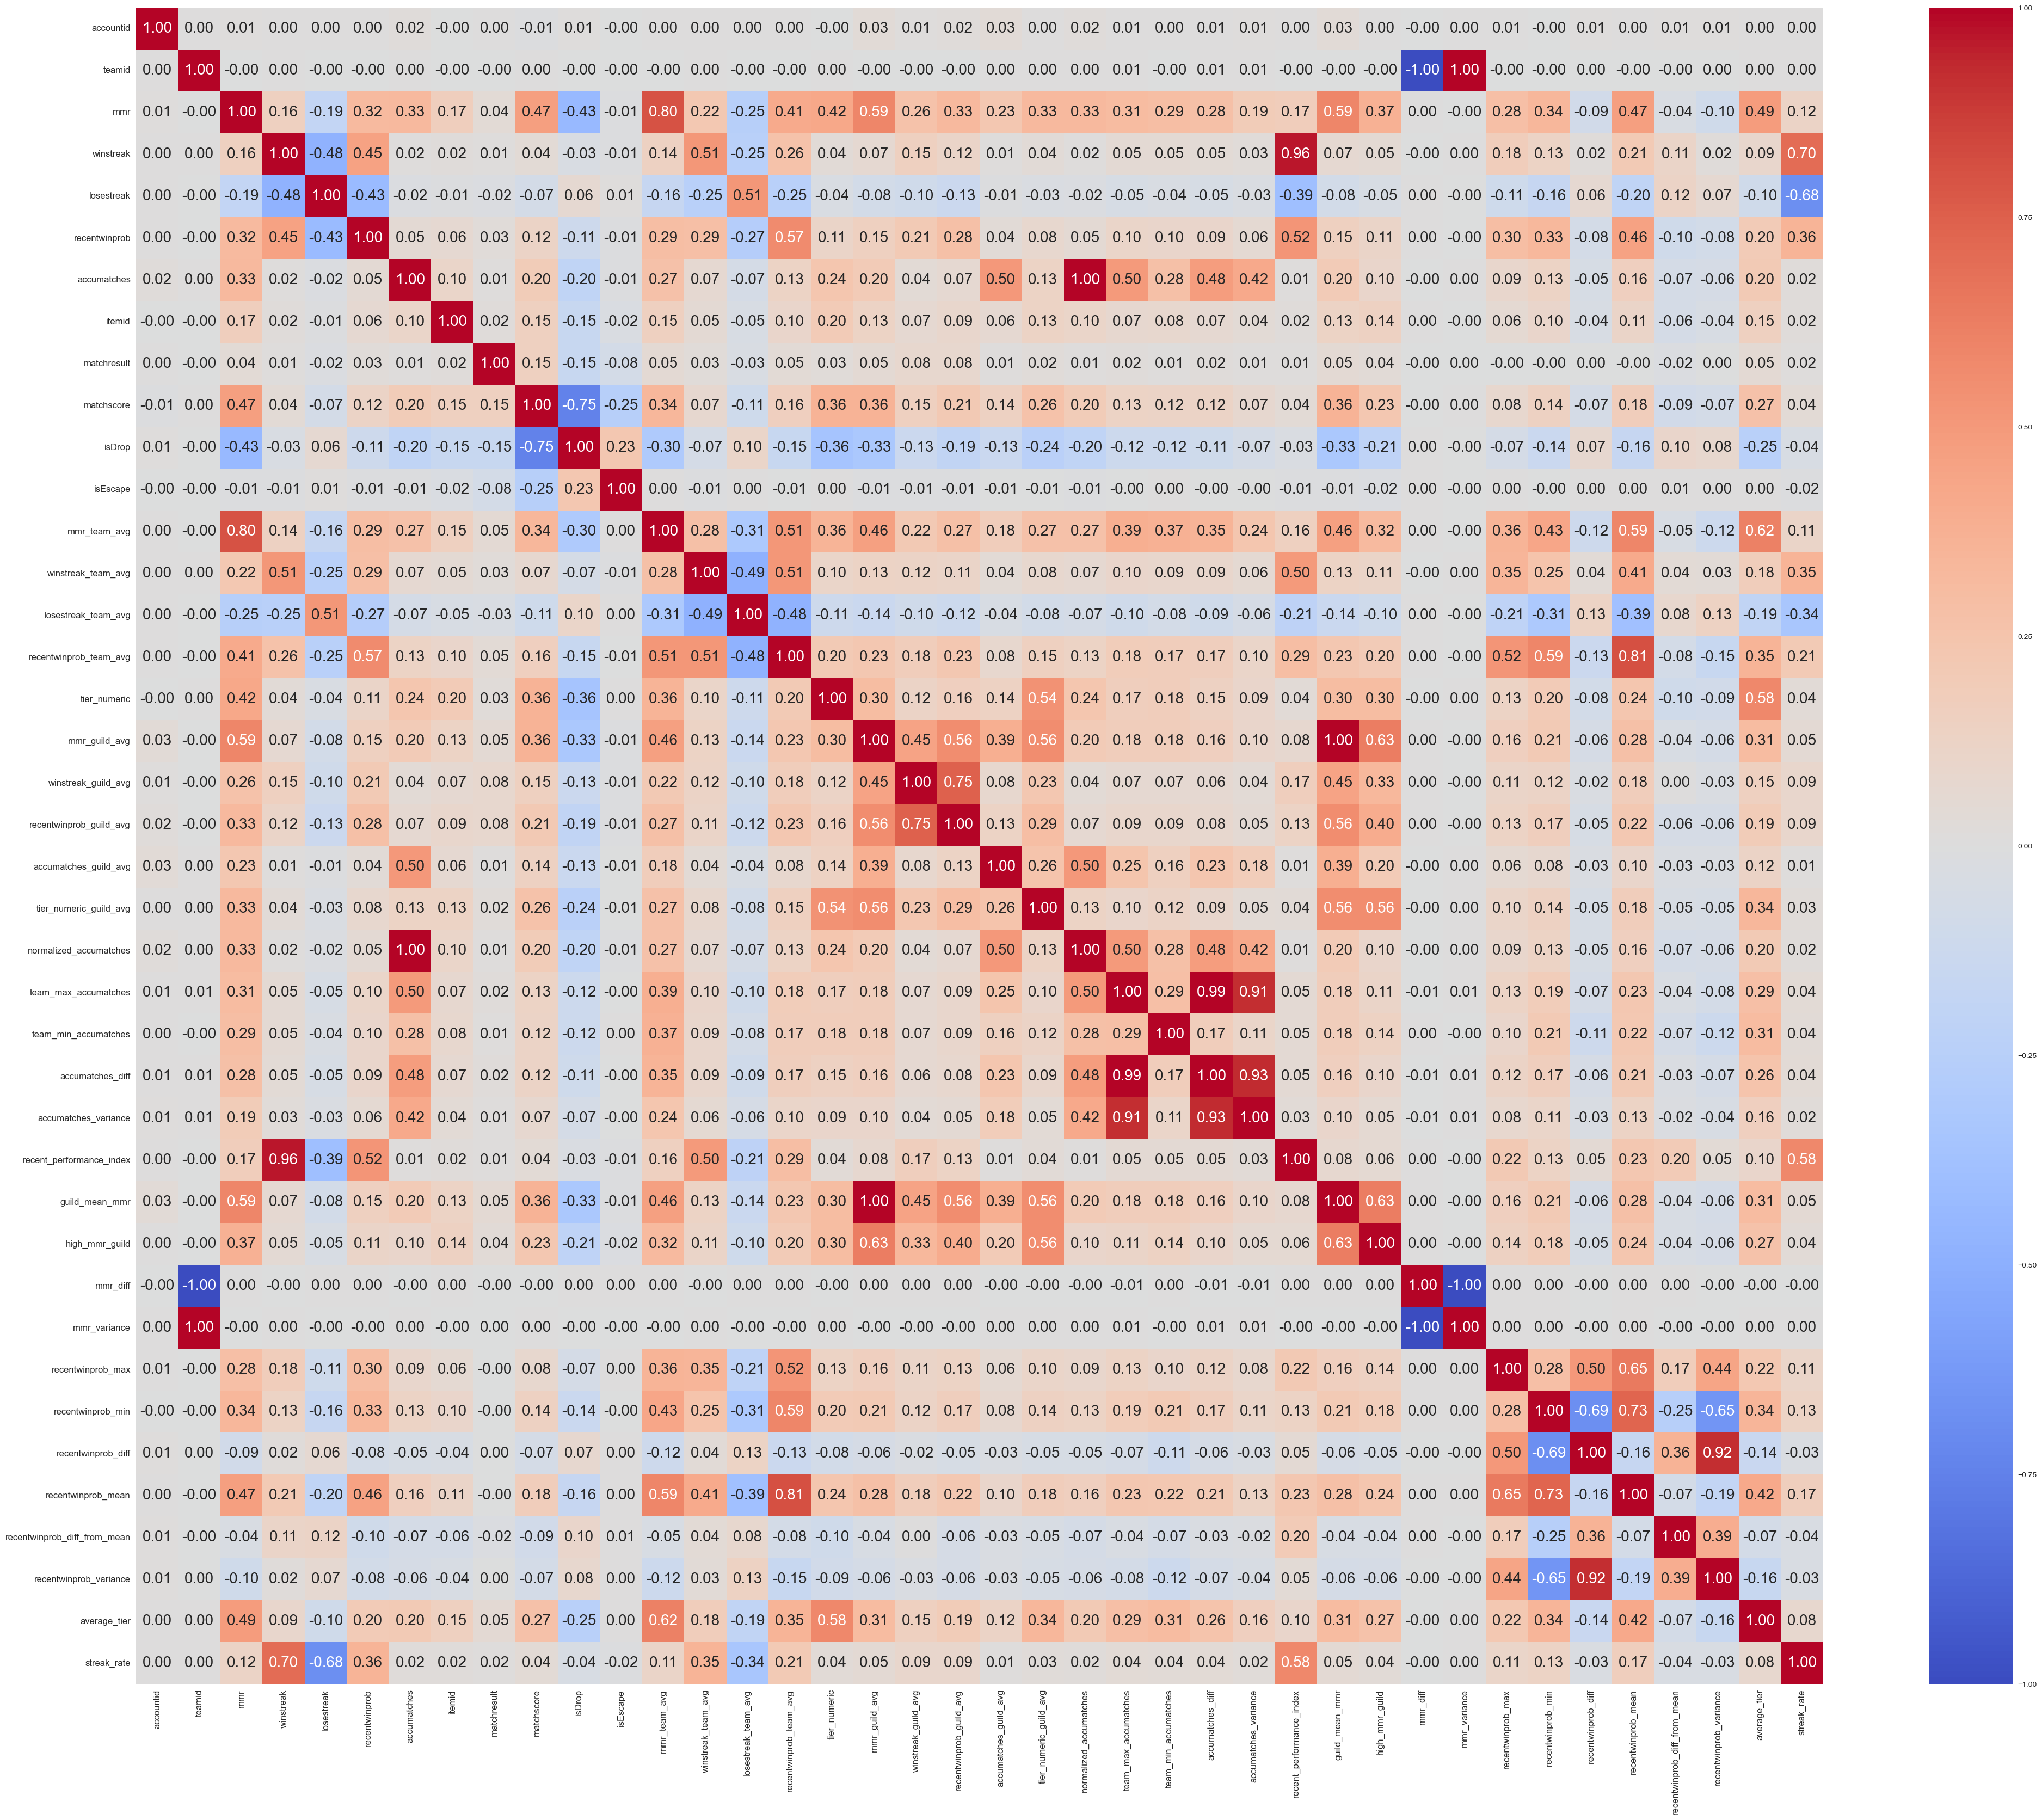

In [21]:
# 문자열 데이터를 포함하는 열을 제거
numeric_data = processed_data.select_dtypes(include=[np.number])

# 상관 행렬 계산
corr_matrix = numeric_data.corr()

plt.figure(figsize=(50, 40))

# 히트맵 표시
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={'size': 20})

# x와 y축의 레이블에 대한 글꼴 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

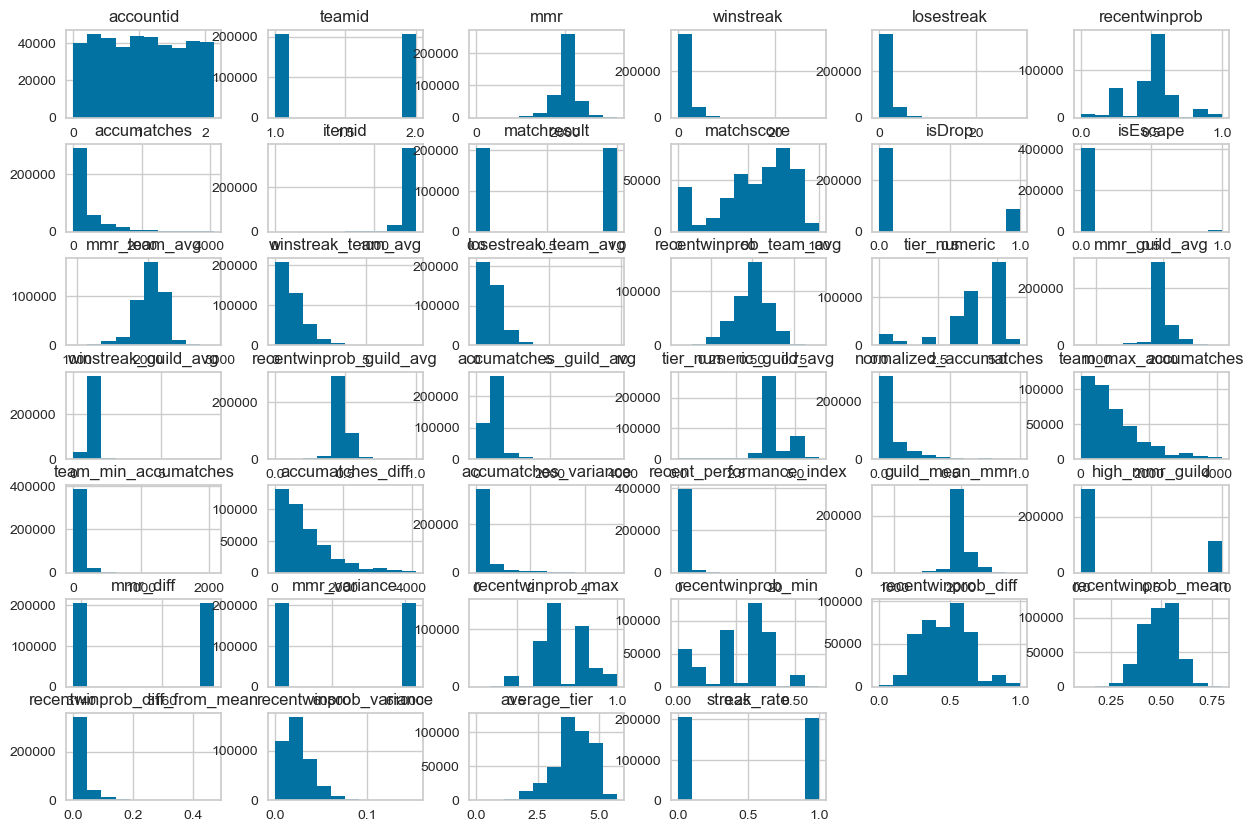

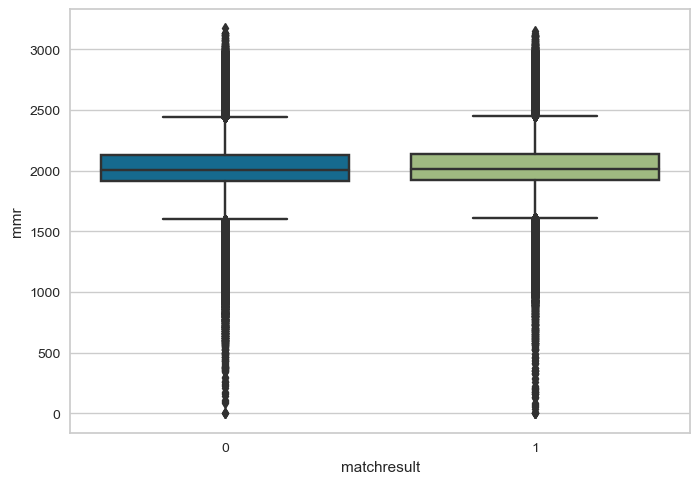

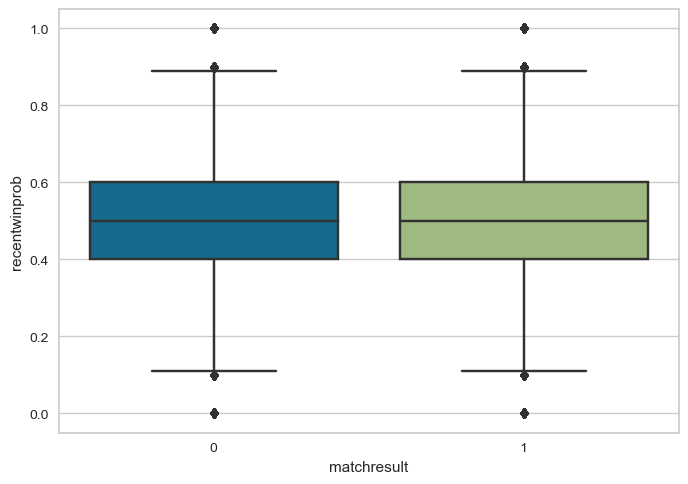

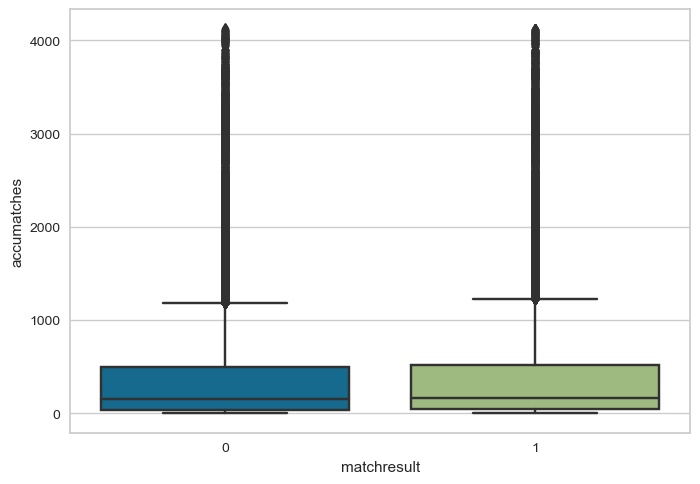

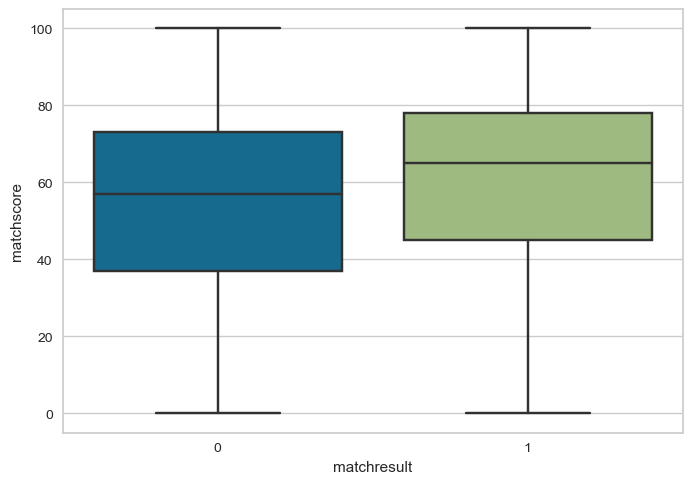

In [10]:
# 수치 특성에 대한 히스토그램
processed_data.hist(figsize=(15,10))
plt.show()

# 매치 결과별 수치 특성에 대한 박스 플롯
for column in ['mmr', 'recentwinprob', 'accumatches', 'matchscore']:
    sns.boxplot(x='matchresult', y=column, data=processed_data)
    plt.show()

In [15]:
# PyCaret 설정
clf1 = setup(data = match_data,
             target = 'matchresult',
             ignore_features = ['createdatekst', 'matchid', 'accountid', 'guildid'],  # 무시할 특성
             ordinal_features = {'tier': ['unranked', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'master']},  # 순서형 특성
             session_id=123)  # 재현 가능성을 위한 세션 ID 설정

,Description,Value
0,Session id,123
1,Target,matchresult
2,Target type,Binary
3,Original data shape,"(410384, 44)"
4,Transformed data shape,"(410384, 46)"
5,Transformed train set shape,"(287268, 46)"
6,Transformed test set shape,"(123116, 46)"
7,Ignore features,4
8,Ordinal features,1
9,Numeric features,38


In [16]:
# 모델 비교를 통해 최적의 모델 선택
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6345,0.6866,0.6479,0.6311,0.6393,0.2691,0.2692,33.0450
et,Extra Trees Classifier,0.6066,0.6509,0.6303,0.6018,0.6157,0.2133,0.2135,38.3920
gbc,Gradient Boosting Classifier,0.5885,0.6316,0.6289,0.5819,0.6045,0.1771,0.1777,48.3560
ada,Ada Boost Classifier,0.5817,0.6215,0.6099,0.5774,0.5932,0.1635,0.1637,10.0920
ridge,Ridge Classifier,0.5757,0.0000,0.6595,0.5648,0.6085,0.1514,0.1536,1.0650
lda,Linear Discriminant Analysis,0.5757,0.6103,0.6593,0.5648,0.6084,0.1513,0.1535,3.0120
knn,K Neighbors Classifier,0.5650,0.5882,0.5672,0.5648,0.5660,0.1301,0.1301,34.2970
dt,Decision Tree Classifier,0.5500,0.5500,0.5502,0.5500,0.5501,0.0999,0.0999,4.4010
nb,Naive Bayes,0.5373,0.5537,0.7680,0.5255,0.6240,0.0746,0.0840,1.2280
lr,Logistic Regression,0.5306,0.5485,0.5387,0.5295,0.5335,0.0612,0.0614,4.0880


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [ ]:
# 모델 생성 및 튜닝 (예: Light Gradient Boosting Machine 선택)
lgbm = create_model('lightgbm')
tuned_lgbm = tune_model(lgbm)

In [ ]:
pc.evaluate_model(lightgbm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
predictions = pc.predict_model(lightgbm_model, data=test_data)

KeyError: "['matchscore', 'isDrop', 'isEscape', 'tier_numeric', 'mmr_guild_avg', 'winstreak_guild_avg', 'recentwinprob_guild_avg', 'accumatches_guild_avg', 'tier_numeric_guild_avg'] not in index"